# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).
#### Download train_32x32.mat e test_32x32.mat and put it in a housenumbers folder


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [2]:
student1 = "Gauthier Mueller"
student2 = "Federico Betti"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [61]:
# all imports, some of them are used to plot
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import random
import copy
import webcolors
from IPython.display import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from keras.optimizers import SGD, Adam
from keras.layers.core import Dense
from keras import regularizers
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.plotly as py
from numpy import mean

# random seed, useless for now
hash_equal = hash(student1 + student2)
np.random.seed(hash_equal % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

### Plotting

In [1]:
# all these functions are used to plot only, no need to be understood, messy code
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [74]:
# this method evaluates the model passed as parameter using the test of the exercise. It prints out the test score
def print_final_rate(model):
    cvscores = []
    scores = model.evaluate(x_test, y_test, verbose=1)
    print("%s: %.2f%%" % ("test score", scores[1]*100))
    return scores

def plot_errors_examples(model, x_test, y_test, batch_size, subset_of_classes):
    yhat = model.predict(x_test, batch_size=batch_size, verbose=0)
    yhat_ind = yhat.argmax(axis=1)
    y_test_ind = y_test.argmax(axis=1)
    error_indices_1 = np.where((yhat_ind == y_test_ind) == False)[0]
    plot_some_samples(x_test, y_test, yhat, error_indices_1, label_mapping = subset_of_classes)
    return error_indices_1
    
def plot_two_models(hist1, title1, hist2, title2):
    x = [i for i in range(0, num_epochs)]

    accuracy1 = hist1.history['val_acc']
    accuracy2 = hist2.history['val_acc']

    plt.figure(figsize=(10, 5))
    plt.title('Evaluate two plots')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(0, 1)
    plt.xlim(-1,num_epochs)

    plt.plot(x, accuracy1, color="red", label=title1)
    plt.plot(x, accuracy2, color="blue", label=title2)
    plt.legend()

    fig1 = plt.gcf()
    plt.show()
    

# this method can be used to plot validation errors of different networks. It needs as first parameter an array
# with all the histories (return from model.fit) of the netowrks to compare
def plot_histories_charact(pair_hist_title, num_epochs, param_to_plot = 'val_acc', title='Histories comparison'):
    x = [i for i in range(0, num_epochs)]
    y_min = 100
    y_max = 0
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(str(param_to_plot))
    plt.grid(True)
    
    for pair in pair_hist_title:
        accuracy = (pair[0].history[param_to_plot])[:num_epochs]
        #if you select more epochs than the number of epochs used for training the line will continue straight
        while(len(accuracy) < num_epochs):
            accuracy.append(accuracy[len(accuracy) - 1])
        if min(accuracy) < y_min:
            y_min = min(accuracy)
        if max(accuracy) > y_max:
            y_max = max(accuracy)
        plt.plot(x, accuracy, label=pair[1])
    
    plt.ylim(y_min - 0.1, y_max + 0.1)
    plt.xlim(-1,num_epochs)
    plt.legend()
    fig1 = plt.gcf()
    plt.show()
    
def get_color_from_rgb(color_t):
    return 'rgb(%d, %d, %d)' %(color_t)

def get_color_trasp_from_rgb(color_t):
    return 'rgba(%d, %d, %d, 0.2)' %(color_t)

#histories is an array that contains all the histrories that you want to compare (i'm comparing val_acc by now,
# it can be easily extended to all features)
init_notebook_mode(connected=True)
def plot_statistics(num_epochs, histories, parameter_to_plot, graph_title = 'plot statistics'):
    colors = ['red', 'green', 'blue', 'black', 'white', 'orange', 'purple', 'brown', 'gray']
    colors_rgb = [webcolors.name_to_rgb(x) for x in colors]
    x = list(range(0, min(num_epochs, len(histories[0].history['val_acc']))))
    x_rev = x[::-1]
    y_min = 100
    y_max = 0
    traces = []
    for p_t_p in parameter_to_plot:
        all_values = []
        for ne in x:
            all_values.append([])
            for hist in histories:
                all_values[ne].append(hist.history[p_t_p][ne])
                
        y1, y1_lower, y1_upper = [], [], []
        for ne in x:
            y1.append(mean(all_values[ne]))
            y1_upper.append(max(all_values[ne]))
            y1_lower.append(min(all_values[ne]))
        y1_lower = y1_lower[::-1]
        
        if max(y1_upper) > y_max:
            y_max = max(y1_upper)
        if min(y1_lower) < y_min:
            y_min = min(y1_lower)
            
        color = colors_rgb[parameter_to_plot.index(p_t_p)]
        c_t = 'rgba(255,0,0,0.2)'
        trace1 = Scatter(
            x=x+x_rev,
            y=y1_upper+y1_lower,
            fill='tozerox',
            fillcolor=get_color_trasp_from_rgb(color),
            line=Line(color='transparent'),
            showlegend=False,
            name=p_t_p,
        )
        trace4 = Scatter(
            x=x,
            y=y1,
            line=Line(color=get_color_from_rgb(color)),
            mode='lines',
            name=p_t_p,
        )
        traces.append(trace1)
        traces.append(trace4)
    
    data = Data(traces)

    layout = Layout(
        title = graph_title,
        paper_bgcolor='rgb(255,255,255)',
        plot_bgcolor='rgb(229,229,229)',
        xaxis=XAxis(
            gridcolor='rgb(255,255,255)',
            range=[1,len(x)],
            showgrid=True,
            showline=False,
            showticklabels=True,
            tickcolor='rgb(127,127,127)',
            ticks='outside',
            zeroline=False,
            title='Epochs'
        ),
        yaxis=YAxis(
            gridcolor='rgb(255,255,255)',
            range=(y_min - 0.1, y_max + 0.1),
            showgrid=True,
            showline=False,
            showticklabels=True,
            tickcolor='rgb(127,127,127)',
            ticks='outside',
            zeroline=False
        ),
    )
    fig = Figure(data=data, layout=layout)
    iplot(fig, filename= 'shaded_lines_first')
    
def plot_statistic_per_number_hidden_line(results, hidden_neurons, parameter_to_plot):
    colors = ['red', 'green', 'blue', 'black', 'white', 'orange', 'purple', 'brown', 'gray']
    colors_rgb = [webcolors.name_to_rgb(x) for x in colors]
    x = list(range(0, min(num_epochs, len(results[0][0].history['val_acc']))))
    x_rev = x[::-1]
    traces = []
    y_min = 100
    y_max = 0
    for hidden_neuron_number in range(len(hidden_neurons)):
        #here i'm trying to plot the line for a single number of hidden neurons
        all_values = []
        for ne in x:
            all_values.append([])
            for hist in results[hidden_neuron_number]:
                all_values[ne].append(hist.history[parameter_to_plot][ne])

        y1, y1_lower, y1_upper = [], [], []
        for ne in x:
            y1.append(np.percentile(all_values[ne], 50))
            y1_upper.append(np.percentile(all_values[ne], 25))
            y1_lower.append(np.percentile(all_values[ne], 75))
        
        y1_lower = y1_lower[::-1]
        
        if max(y1_upper) > y_max:
            y_max = max(y1_upper)
        if min(y1_lower) < y_min:
            y_min = min(y1_lower)

        color = colors_rgb[hidden_neuron_number]
        c_t = 'rgba(255,0,0,0.2)'
        trace1 = Scatter(
            x=x+x_rev,
            y=y1_upper+y1_lower,
            fill='tozerox',
            fillcolor=get_color_trasp_from_rgb(color),
            line=Line(color='transparent'),
            showlegend=False,
            name=str(hidden_neurons[hidden_neuron_number]),
        )
        trace4 = Scatter(
            x=x,
            y=y1,
            line=Line(color=get_color_from_rgb(color)),
            mode='lines',
            name=str(hidden_neurons[hidden_neuron_number]),
        )
        traces.append(trace1)
        traces.append(trace4)
    
    data = Data(traces)

    layout = Layout(
        paper_bgcolor='rgb(255,255,255)',
        plot_bgcolor='rgb(229,229,229)',
        title= '25-50-75 percentile of networks with ' + str(hidden_neurons) + ' hidden neurons',
        xaxis=XAxis(
            gridcolor='rgb(255,255,255)',
            range=[1,len(x)],
            showgrid=True,
            showline=False,
            showticklabels=True,
            tickcolor='rgb(127,127,127)',
            ticks='outside',
            zeroline=False,
            title=parameter_to_plot
        ),
        yaxis=YAxis(
            gridcolor='rgb(255,255,255)',
            showgrid=True,
            showline=False,
            showticklabels=True,
            tickcolor='rgb(127,127,127)',
            ticks='outside',
            zeroline=False,
            title='epochs'
        ),
    )
    fig = Figure(data=data, layout=layout)
    iplot(fig, filename= 'shaded_lines_first')
    py.image.save_as(fig, filename='prova.png')
    
    Image('prova.png')

    
def plot_statistic_per_number_hidden(results, hidden_neurons, parameter_to_plot):
    colors = ['red', 'green', 'blue', 'black', 'white', 'orange', 'purple', 'brown', 'gray']
    # results[number of hidden neuron][different random seed]
    traces = []
    #per ogni numero di hidden_neurons prendo il parametro to plot giusto all'ultima epoch
    for h_n_index in range(len(hidden_neurons)):
        for p_t_p in parameter_to_plot:
            y_hist = []
            for hist in results[h_n_index]:
                y_hist.append(hist.history[p_t_p][-1])
            trace = Box(
                y = y_hist,
                name = "h_n=" + str(hidden_neurons[h_n_index]) + ' ' + p_t_p,
                line = dict(
                    color = colors[parameter_to_plot.index(p_t_p)])
                )
            traces.append(trace)
    
    data = traces
    
    title = parameter_to_plot[0]
    for t in parameter_to_plot[1:]:
        title = title + ', ' + t
    layout = Layout(
        title = title + ' per hidden neurons in the last epoch'
    )

    fig = Figure(data=data,layout=layout)
    iplot(fig, filename = "Prova")
    
        
def matplotlib_plot_statistic_per_number_hidden(results, hidden_neurons, parameter_to_plot):
    colors = ['blue']
    fig, axes = plt.subplots(ncols=1, nrows=len(parameter_to_plot), figsize=(9, 4))
    bplot1 = []
    
    for i in range(len(parameter_to_plot)):
        p_t_p = parameter_to_plot[i]
        # results[number of hidden neuron][different random seed]
        traces = []
        #per ogni numero di hidden_neurons prendo il parametro to plot giusto all'ultima epoch
        for h_n_index in range(len(hidden_neurons)):
            y_hist = []
            for hist in results[h_n_index]:
                y_hist.append(hist.history[p_t_p][-1])
            traces.append(y_hist)
        
        if len(parameter_to_plot) > 1:
            bplot1.append(axes[i].boxplot(traces, vert=True, patch_artist=True))
        else:
            bplot1 = axes.boxplot(traces, vert=True, patch_artist=True)
            
    
    
    # adding horizontal grid lines
    if len(parameter_to_plot) > 1:
        for b_p in bplot1:
            for patch, color in zip(b_p['boxes'], colors):
                patch.set_facecolor(color)
        for ax in axes:
            ax.yaxis.grid(True)
            ax.set_xticks([y+1 for y in range(len(traces))], )
            ax.set_xlabel('Number of hidden neurons')
            param = parameter_to_plot[(list(axes).index(ax))]
            ax.set_title('Statistics about ' + param + ' for different number of hidden neurons' )
            ax.set_ylabel(param)
    else:
        for patch, color in zip(bplot1['boxes'], colors):
            patch.set_facecolor(color)
        
        axes.yaxis.grid(True)
        axes.set_xticks([y+1 for y in range(len(traces))], )
        axes.set_xlabel('Number of hidden neurons')
        axes.set_ylabel(parameter_to_plot[0])
        axes.set_title('Statistics about ' + parameter_to_plot[0] + ' for different number of hidden neurons' )
        

    # add x-tick labels
    plt.setp(axes, xticks=[y+1 for y in range(len(traces))],
             xticklabels=hidden_neurons)

    plt.show()
    
# histories = list of histories
def plot_all_statistic_of_history(histories, parameter_to_plot, name):
    x_len = len(histories[0].history['loss'])
    x = [i for i in range(x_len)]
    x_rev = x[::-1]
    
    all_values = []
    for ne in x:
        all_values.append([])
        for hist in histories:
            all_values[ne].append(hist.history[parameter_to_plot][ne])

    _25_perc, _50_perc, _75_perc, mean, std_up, std_dn, y_max, y_min = [], [], [], [], [], [], [], []
    for ne in x:
        mean_ = np.mean(all_values[ne])
        mean.append(mean_)
        std_dn.append(mean_ - np.std(all_values[ne]))
        std_up.append(mean_ + np.std(all_values[ne]))
        y_max.append(max(all_values[ne]))
        y_min.append(min(all_values[ne]))
        _25_perc.append(np.percentile(all_values[ne], 25))
        _50_perc.append(np.percentile(all_values[ne], 50))
        _75_perc.append(np.percentile(all_values[ne], 75))
    
    plt.figure(figsize=(10, 5))
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('History Statistics')
    plt.grid(True)
    plt.ylim(max(y_min) - 0.1, min(y_max) + 0.1)
    plt.xlim(-1,num_epochs)
    
    plt.plot(x, mean, label="mean")
    plt.plot(x, std_dn, label="-std", color='red')
    plt.plot(x, std_up, label="+std", color='red')
    plt.plot(x, y_max, label="max")
    plt.plot(x, y_min, label="min")
    plt.plot(x, _25_perc, label="25° percentile")
    plt.plot(x, _50_perc, label="50° percentile")
    plt.plot(x, _75_perc, label="75° percentile")
    plt.legend()

    fig1 = plt.gcf()
    plt.show()
     

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [6]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [7]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

# just five classes of numbers are extracted
x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

[5 2 1 8 7]


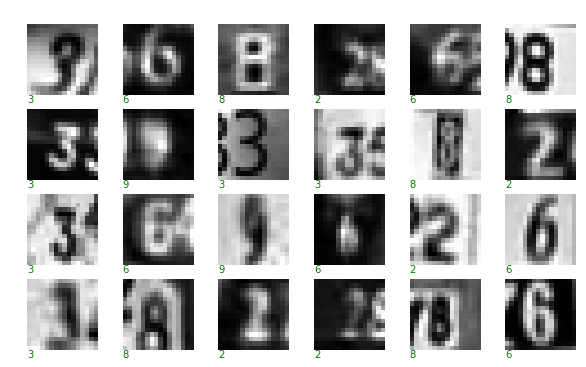

In [8]:
print(subset_of_classes) # print which are the classes extracted
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes); # plot some samples of extracted classes

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [9]:
y_train = keras.utils.to_categorical(y_train) # to put in one-hot encoding format
y_test = keras.utils.to_categorical(y_test)

In [10]:
# x_train_shuffled and y_train_shuffled have the same data of the normal ones but in a randomly mixed order, 
# sometimes it is usefull to improve performances and reduce overfitting
x_train_shuffled = copy.copy(x_train)
y_train_shuffled = copy.copy(y_train)
combined = list(zip(x_train_shuffled, y_train_shuffled))
random.shuffle(combined)

x_train_shuffled[:], y_train_shuffled[:] = zip(*combined)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [10]:
# first attempt of netowrk with stocastic gradient descent
num_epochs = 200
batch_size = 128
model_SGD = Sequential() # create NN model
model_SGD.add(Dense(5, input_dim=256, activation='softmax')) # add layer

optimizer_SGD = SGD(lr=0.01, decay=0, momentum=0, nesterov=False) # create optimizer

model_SGD.compile(loss='categorical_crossentropy',
              optimizer=optimizer_SGD,
              metrics=['acc']) # compile the model

# train the model. It gives as output all the history of training, used to plot info afterwards
hist_first_SGD = model_SGD.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))

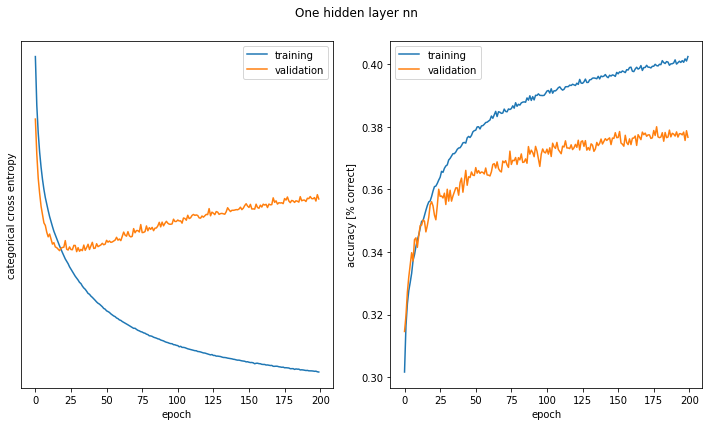

In [11]:
_ = plot_history(hist_first_SGD, 'One hidden layer nn')
# It is overfitting!

In [12]:
print_final_rate(model_SGD) # this print the TEST score of the model

15767/15767 [==============================] - 0s 16us/step
test score: 37.67%


[1.5282824808380695, 0.3766727976048765]

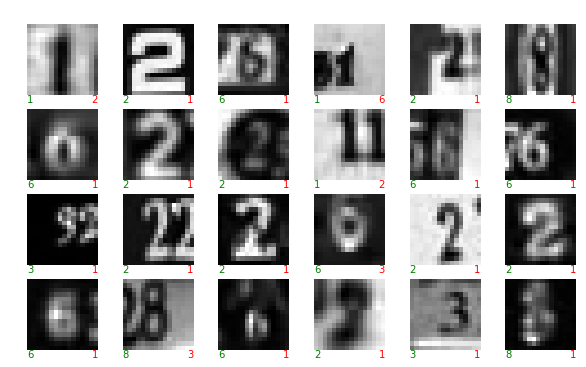

In [13]:
# with plot_errors_examples it shows which are the input that are missclassified by the network.
error_indices = plot_errors_examples(model_SGD, x_test, y_test, batch_size, subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [36]:
# 1.
num_epochs = 50
batch_size = 128

def one_hidden_layer(optimizer):
    model = Sequential()
    model.add(Dense(64, input_dim=256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
    return model
    
model = one_hidden_layer(SGD(lr=0.01, decay=0.0, momentum=0.0, nesterov=False))

hist_sgd = model.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
print_final_rate(model)
# 1. print the summary of the model
model.summary()

9499/9499 [==============================] - 0s 33us/step
test score: 62.98%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_162 (Dense)            (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [37]:
#2. change the learing rate. 4 attempts_ 0.1
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 10]
num_epochs = 50
batch_size = 128
to_plot = []

for lr in learning_rates:
    print("learning rate: %f", lr)
    model_different_lr = one_hidden_layer(SGD(lr=lr, decay=0.0, momentum=0.0, nesterov=False))
    hist = model_different_lr.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
    print_final_rate(model_different_lr)
    to_plot.append([hist, 'sgd with lr = ' + str(lr)])

learning rate: %f 0.0001
9499/9499 [==============================] - 0s 30us/step
test score: 24.87%
learning rate: %f 0.001
9499/9499 [==============================] - 0s 29us/step
test score: 27.66%
learning rate: %f 0.01
9499/9499 [==============================] - 0s 29us/step
test score: 63.12%
learning rate: %f 0.1
9499/9499 [==============================] - 0s 29us/step
test score: 79.47%
learning rate: %f 1
9499/9499 [==============================] - 0s 30us/step
test score: 73.05%
learning rate: %f 10
9499/9499 [==============================] - 0s 31us/step
test score: 17.48%


**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is sufficiently large, it will make the SGD method overshoot.

B) If the learning rate is very small the network is slow to learn and to change its weights, because the steps taken are very small. It will converge but slowly.

In [38]:
#3. replace the SGD with adam optmizer and check the result
batch_size = 128
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_adam = one_hidden_layer(adam)

hist_adam = model_adam.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
print_final_rate(model_adam)
model_adam.summary()
to_plot.append([hist_adam, 'adam model'])

9499/9499 [==============================] - 0s 30us/step
test score: 66.22%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_176 (Dense)            (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


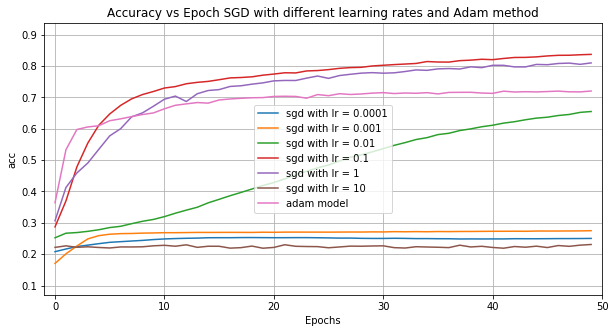

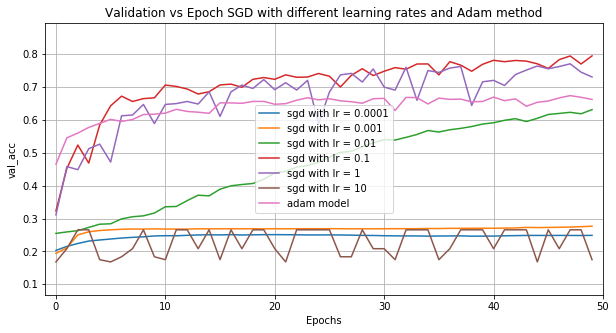

In [43]:
g =  'vs Epoch SGD with different learning rates and Adam method'

# plot all networks with different learning rates and optimizers to compare them
plot_histories_charact(to_plot, num_epochs, 'acc', 'Accuracy ' + g)
plot_histories_charact(to_plot, num_epochs, 'val_acc', 'Validation ' + g)

We decided to split the graphs, because otherwise it would be too messy.
We can see that the accuracy and also validation accuracy for SGD with lr=0.1 and lr=1 are comparable with the Adam method. Instead, with lr too small or too big, we can see that it has the problems described in ex3.

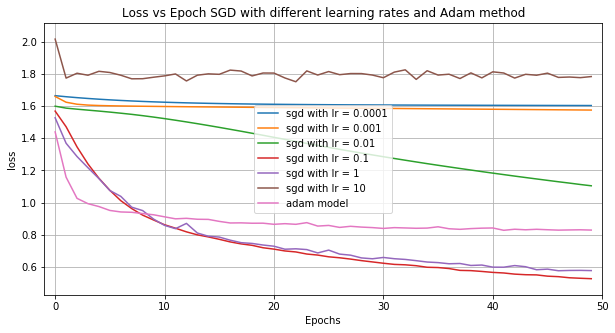

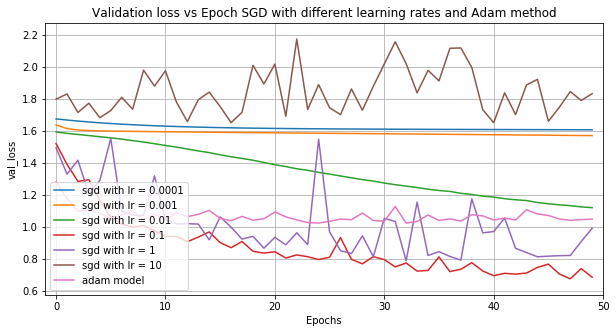

In [42]:
plot_histories_charact(to_plot, num_epochs, 'loss', 'Loss ' + g)
plot_histories_charact(to_plot, num_epochs, 'val_loss', 'Validation loss ' + g)

We can do the same observation as for the accuracy. SGD with lr=0.1, 1 performs well, but it shows more noise with relatively high learning rates.

learning rate: %f 0.0001
15767/15767 [==============================] - 0s 18us/step
test score: 26.21%
learning rate: %f 0.001
15767/15767 [==============================] - 0s 19us/step
test score: 26.83%
learning rate: %f 0.01
15767/15767 [==============================] - 0s 18us/step
test score: 61.93%
learning rate: %f 0.1
15767/15767 [==============================] - 0s 19us/step
test score: 82.06%
learning rate: %f 1
15767/15767 [==============================] - 0s 19us/step
test score: 72.07%
learning rate: %f 10
15767/15767 [==============================] - 0s 23us/step
test score: 26.31%
15767/15767 [==============================] - 0s 21us/step
test score: 60.04%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_31 (Dense)             (None, 5)          

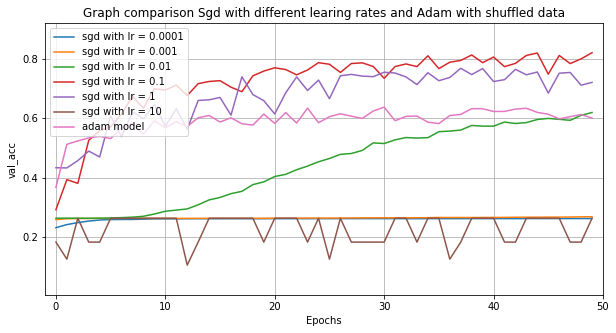

In [18]:
# USELESS RESULT
# now i'm going to do the same thing but using test and training data randomly mixed (not all 1s at the beginning and so on)
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 10]
num_epochs = 50
batch_size = 128
to_plot = []

for lr in learning_rates:
    print("learning rate: %f", lr)
    model_different_lr = one_hidden_layer(SGD(lr=lr, decay=0, momentum=0, nesterov=False))
    hist = model_different_lr.fit(x_train_shuffled, y_train_shuffled, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
    print_final_rate(model_different_lr)
    to_plot.append([hist, 'sgd with lr = ' + str(lr)])
    
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_adam = one_hidden_layer(adam)
hist_adam = model_adam.fit(x_train_shuffled, y_train_shuffled, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
print_final_rate(model_adam)
model_adam.summary()
to_plot.append([hist_adam, 'adam model'])

plot_histories_charact(to_plot, num_epochs, 'val_acc', graph_title + ' with shuffled data')

We tried to compare the results using shuffled data. We can see that it is similar, but less smooth.

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [19]:
#3. replace the SGD with adam optmizer and check the result
num_epochs = 150
batch_size = 128

adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_adam = one_hidden_layer(adam)

hist_adam_500 = model_adam.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
print_final_rate(model_adam)
# 80% on test score, remember if you want to plot errors plot_errors_example()

15767/15767 [==============================] - 0s 20us/step
test score: 80.58%


[0.7433899772895299, 0.8057969176429782]

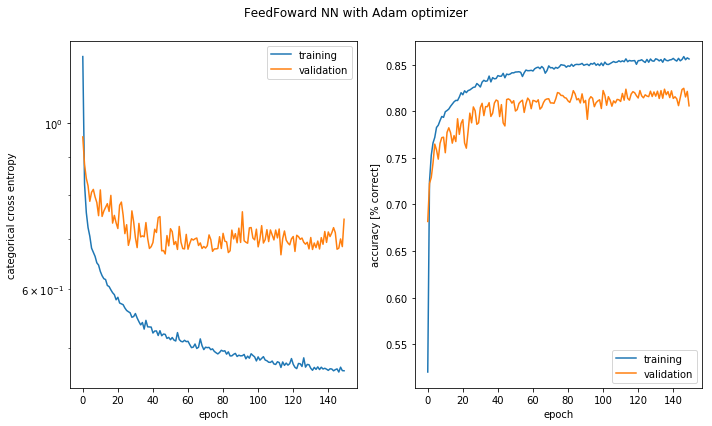

In [20]:
_ = plot_history(hist_adam_500, 'FeedFoward NN with Adam optimizer')
# with ADAM the validation accuracy, as well as test accuracy is increasing.

In [21]:
# now i'm going to test the net with randomly mixed train data
num_epochs = 150
batch_size = 128

adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_adam = one_hidden_layer(adam)

hist_adam_500_shuffled = model_adam.fit(x_train_shuffled, y_train_shuffled, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
print_final_rate(model_adam)

15767/15767 [==============================] - 0s 19us/step
test score: 69.72%


[1.0519905584838505, 0.6972157037000329]

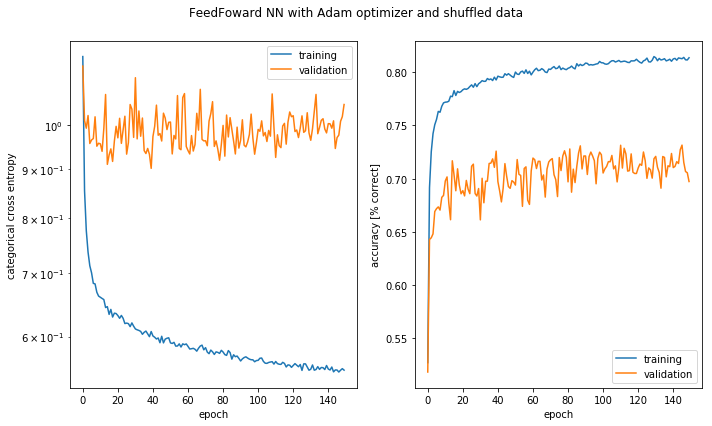

In [22]:
_ = plot_history(hist_adam_500_shuffled, 'FeedFoward NN with Adam optimizer and shuffled data')

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: As seen from the graph above the model begins to overfit around the 35-th epoch, since until 35 is still decreasing overall. You can see from the fact that the error on the test dataset starts to rise and that the accuracy on the training dataset becomes greater than the test one, it means that the network has begun to learn 'by heart' the training dataset, hence overfitting.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: W.r.t overfitting the training data loss curve will decrease, while the loss curve of validation will increase. The accuracy of the training data will increase but the accuracy of the validation data does not necessarly decrease, because the threshold to change class is not reached yet. For example, in a classification problem, ([0.2,0.7, ...]) and ([0.2,0.3,...]), such that the second component is the greatest one, have different loss values, but same accuracy if we take the index of the max value.


15767/15767 [==============================] - 0s 22us/step
test score: 75.79%


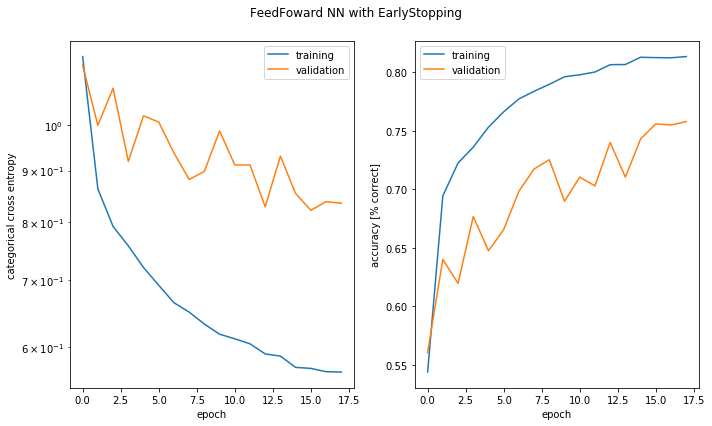

In [23]:
#starting use the early stopping algorithm, running test with it to paragonate the result with the previous ones
#testing on the last adam netowrk
#earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.1,
                              patience=10,
                              verbose=0, mode='auto')

num_epochs = 150
batch_size = 128

adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_adam_earlys = one_hidden_layer(adam)

hist_adam_earlys = model_adam_earlys.fit(x_train_shuffled, y_train_shuffled, callbacks=[earlyStopping], epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
print_final_rate(model_adam_earlys)
_ = plot_history(hist_adam_earlys, 'FeedFoward NN with EarlyStopping')

number of errors: 4774
percentage of error: 30.278429631508846


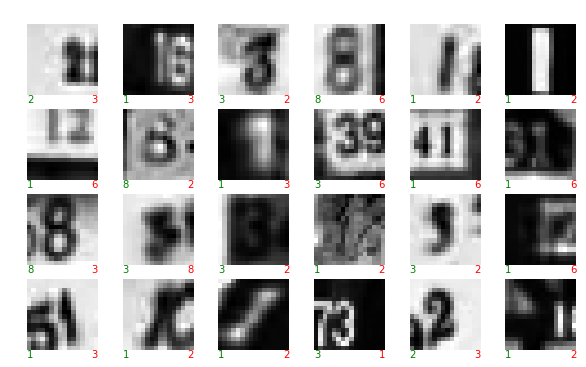

In [24]:
#in this section i would like to show which are the images that the network misjudges
predictions = model_adam.predict(x_test)
error_indices = plot_errors_examples(model_adam, x_test, y_test, batch_size, subset_of_classes)

print("number of errors:", len(error_indices))
print("percentage of error:", (float(len(error_indices))/len(predictions))*100)

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [12]:
def one_hidden_nht_layer(optimizer, nht):
    model = Sequential()
    model.add(Dense(nht, input_dim=256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
    return model
    
#1 i'm going to test the net with a different number of hidden neurons
number_hidden_test = [10, 32, 64, 128, 256, 512, 1000]
num_epochs = 25
batch_size = 128
results = []
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

for nht in number_hidden_test:
    print('Model with number of neurons in the hidden layer:', nht)
    model_adam = one_hidden_nht_layer(adam, nht)
    hist_adam_500_shuffled = model_adam.fit(x_train_shuffled, y_train_shuffled, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
    results.append(hist_adam_500_shuffled)

Model with number of neurons in the hidden layer: 10
Model with number of neurons in the hidden layer: 32
Model with number of neurons in the hidden layer: 64
Model with number of neurons in the hidden layer: 128
Model with number of neurons in the hidden layer: 256
Model with number of neurons in the hidden layer: 512
Model with number of neurons in the hidden layer: 1000


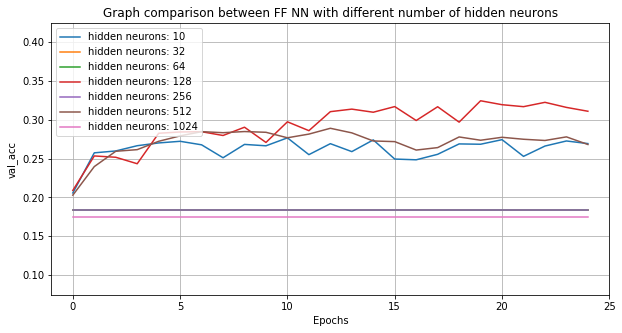

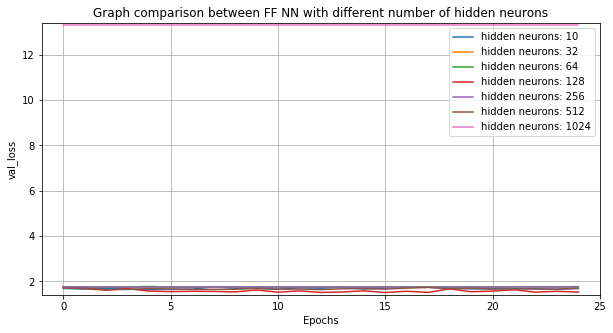

In [11]:
# plot all the curves obtained in different graphs
to_plot_valid_errors = []
for res, num in zip(results, number_hidden_test):
    to_plot_valid_errors.append([res, 'hidden neurons: ' + str(num)])
    
graph_title = 'Graph comparison between FF NN with different number of hidden neurons'
plot_histories_charact(to_plot_valid_errors, num_epochs, 'val_acc', graph_title)
plot_histories_charact(to_plot_valid_errors, num_epochs, 'val_loss', graph_title)

In [65]:
#now i'm going to do the same test as before using different initial conditions, trying to plot them correctly
number_hidden_test = [10, 32, 64, 128, 256, 512, 1000]
#number_hidden_test = [10, 32, 64]
results = []
for r in number_hidden_test:
    results.append([])
#number_hidden_test = [10]
num_epochs = 30
batch_size = 128
# results[number of hidden neuron][different random seed]
max_random = pow(2,32) - 1
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

for i in range(0,10):
    print('initial condition:',i)
    for nht in number_hidden_test:
        #print('Model with number of neurons in the hidden layer:', nht)
        model_adam = one_hidden_nht_layer(adam, nht)

        hist_adam_500_shuffled = model_adam.fit(x_train_shuffled, y_train_shuffled, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
        # i stored all the results in 'results', used after to plot them
        results[number_hidden_test.index(nht)].append(hist_adam_500_shuffled)

initial condition: 0
initial condition: 1
initial condition: 2
initial condition: 3
initial condition: 4
initial condition: 5
initial condition: 6
initial condition: 7
initial condition: 8
initial condition: 9


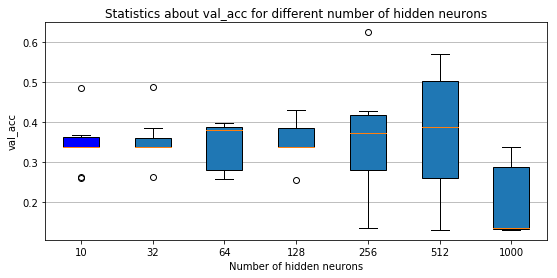

In [75]:
matplotlib_plot_statistic_per_number_hidden(results_plot, hidden_num, ['val_acc'])

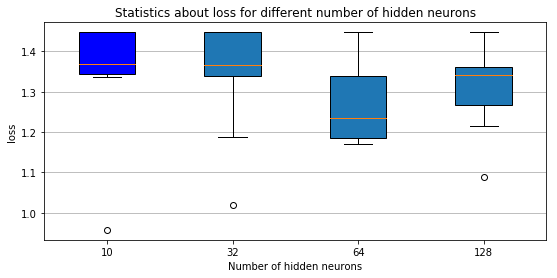

In [76]:
matplotlib_plot_statistic_per_number_hidden(results_plot[:-3], hidden_num[:-3], ['loss'])

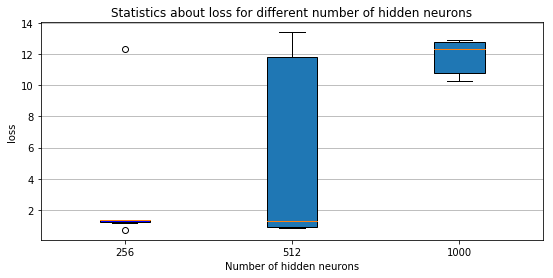

In [84]:
matplotlib_plot_statistic_per_number_hidden(results_plot[4:], hidden_num[4:], ['loss'])

We have decided to separate the last two graphs beacuse they have a completly different scale

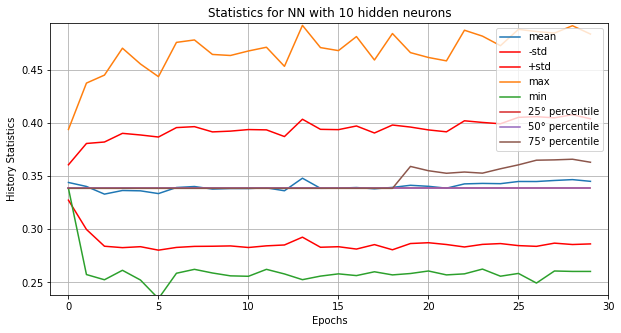

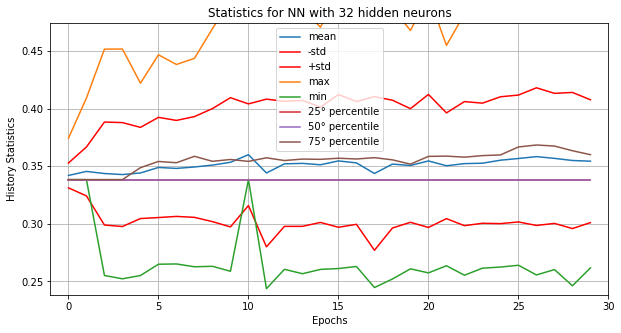

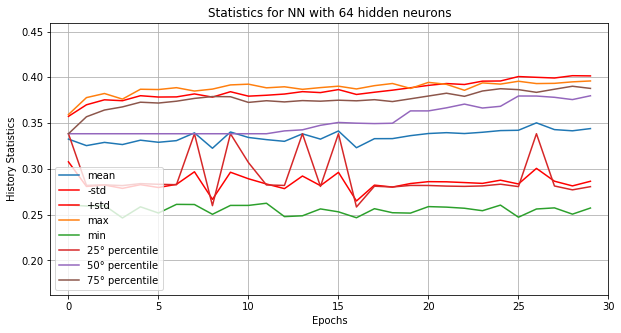

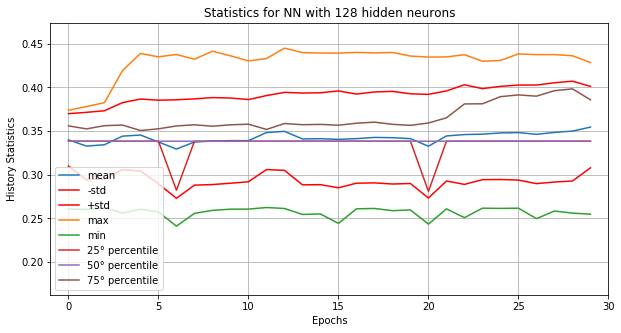

In [78]:
for i in range(0, len(results) - 3):
    plot_all_statistic_of_history(results[i], 'val_acc', 'Statistics for NN with ' + str(number_hidden_test[i]) + ' hidden neurons')

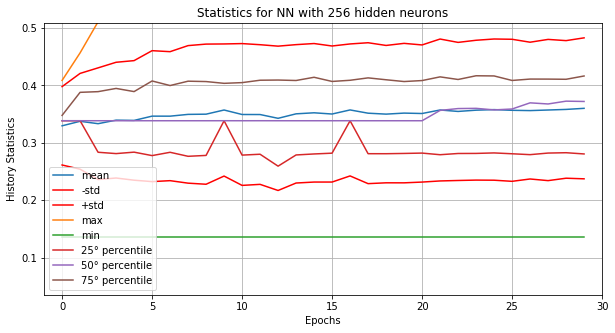

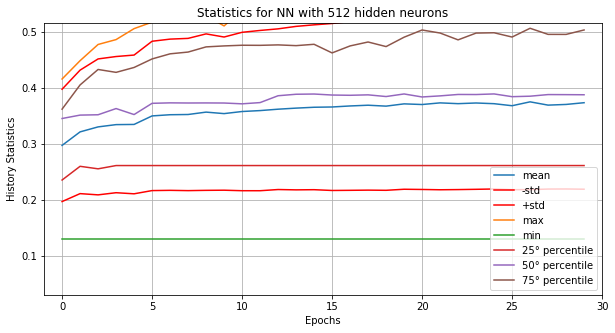

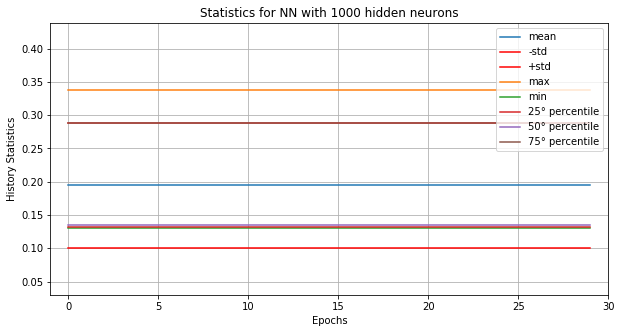

In [81]:
for i in range(len(results) - 3, len(results)):
    plot_all_statistic_of_history(results[i], 'val_acc', 'Statistics for NN with ' + str(number_hidden_test[i]) + ' hidden neurons')

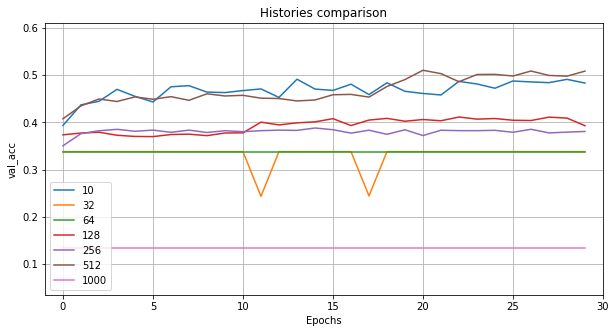

In [86]:
to_compare = []
for res, hidd in zip(results, number_hidden_test):
    to_compare.append([res[0], str(hidd)])
plot_histories_charact(to_compare, num_epochs)

Comparison of validation accuracy between different numbers of hidden neurons

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [17]:
def run_adam_model(hidden_layer = 1, num_epochs = 40, batch_size = 128, useEarlyStopping = False):
    
    earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

    model_adam_multilayer = Sequential()
    if hidden_layer == 1:
        model_adam_multilayer.add(Dense(100, input_dim=256, activation='relu'))
    elif hidden_layer == 2:
        model_adam_multilayer.add(Dense(88, input_dim=256, activation='relu'))
        model_adam_multilayer.add(Dense(48, activation='relu'))
    elif hidden_layer == 3:
        model_adam_multilayer.add(Dense(88, input_dim=256, activation='relu'))
        model_adam_multilayer.add(Dense(36, activation='relu'))
        model_adam_multilayer.add(Dense(16, activation='relu'))
    elif hidden_layer == 4:
        model_adam_multilayer.add(Dense(84, input_dim=256, activation='relu'))
        model_adam_multilayer.add(Dense(38, activation='relu'))
        model_adam_multilayer.add(Dense(18, activation='relu'))
        model_adam_multilayer.add(Dense(10, activation='relu'))        
    else:
        print("not supported number of hidden layers")
        
    # last layer equal for all networks
    model_adam_multilayer.add(Dense(5, activation='softmax'))

    adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_adam_multilayer.compile(loss='categorical_crossentropy',
                  optimizer= adam,
                  metrics=['acc'])
    model_adam_multilayer.summary()
    if useEarlyStopping:
        hist = model_adam_multilayer.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, verbose=0, callbacks=[earlyStopping], validation_data=(x_test, y_test))
        scores = print_final_rate(model_adam_multilayer)
        return hist, scores
    else:
        hist = model_adam_multilayer.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
        scores = print_final_rate(model_adam_multilayer)
        return hist, scores
        

In [59]:
hidden_layer = [1, 2, 3, 4]
multilayer_results = []
num_epochs = 50
batch_size = 128

for i in hidden_layer:
    best = 0
    hist = []
    for j in range(3):
        adam_multilayer_history2, scores = run_adam_model(hidden_layer = i)
        score = scores[1]
        if best < score:
            best = score
            hist = adam_multilayer_history2
    multilayer_results.append([hist, str(i) + " hidden layers"])
    
# for i in hidden_layer:
#     adam_multilayer_history2 = run_adam_model(hidden_layer = i)
#     multilayer_results.append([adam_multilayer_history2, str(i) + " hidden layers"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_203 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_204 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
9499/9499 [==============================] - 0s 33us/step
test score: 68.86%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_205 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_206 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________

9499/9499 [==============================] - 0s 38us/step
test score: 70.93%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 84)                21588     
_________________________________________________________________
dense_236 (Dense)            (None, 38)                3230      
_________________________________________________________________
dense_237 (Dense)            (None, 18)                702       
_________________________________________________________________
dense_238 (Dense)            (None, 10)                190       
_________________________________________________________________
dense_239 (Dense)            (None, 5)                 55        
Total params: 25,765
Trainable params: 25,765
Non-trainable params: 0
_________________________________________________________________
9499/9499 [==============================] - 0s 38us/step
tes

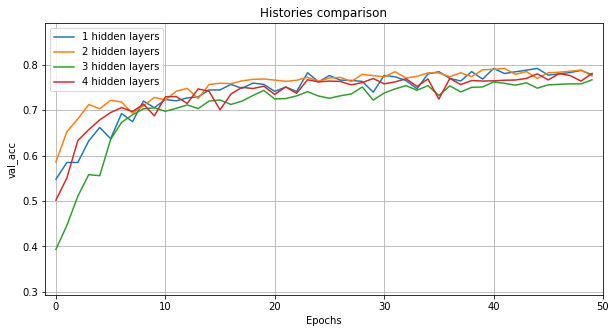

In [61]:
results_to_plot = multilayer_results[:][0]
plot_histories_charact(multilayer_results, num_epochs)

In [92]:
plot_statistics(num_epochs, [x[0] for x in multilayer_results], ['val_acc', 'acc'], 'Accuracy statistics for different numbers of layers')
plot_statistics(num_epochs, [x[0] for x in multilayer_results], ['loss', 'val_loss'], 'Loss statistics for different numbers of layers')

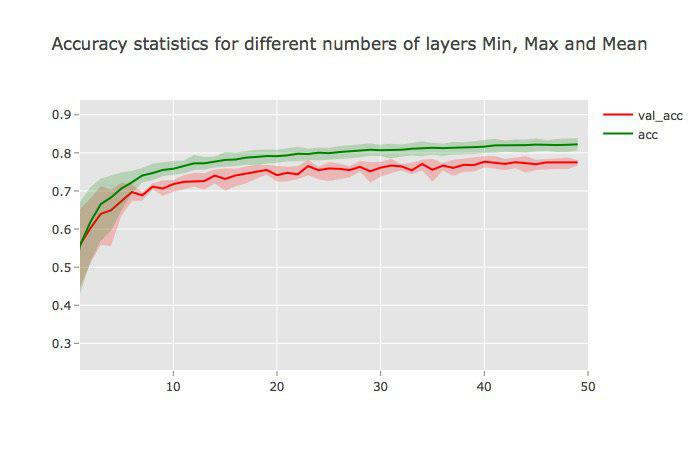

In [90]:
Image(filename='plot_loss5.png')

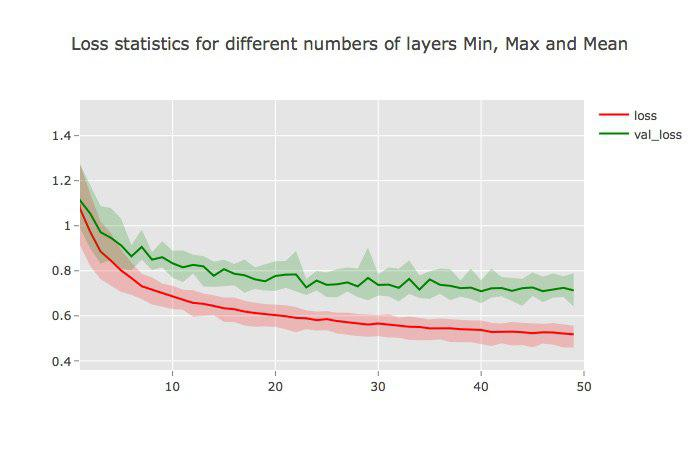

In [89]:
Image(filename='plot_acc5.png')

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [21]:
# the best validation error results for adam optimized networks with 1 and 4 layers are respectivly 87,01% and 86,68%

#test with a net found online
# instantiate model
num_epochs = 50
batch_size = 128
model_online = Sequential()

# we can think of this chunk as the input layer
model_online.add(Dense(128, input_dim=256))
model_online.add(BatchNormalization())
model_online.add(Activation('relu'))
model_online.add(Dropout(0.5))

# we can think of this chunk as the hidden layer    
model_online.add(Dense(64))
model_online.add(BatchNormalization())
model_online.add(Activation('relu'))
model_online.add(Dropout(0.5))

# we can think of this chunk as the output layer
model_online.add(Dense(5))
model_online.add(BatchNormalization())
model_online.add(Activation('softmax'))

# setting up the optimization of our weights 
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model_online.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
history_online_net_sgd = model_online.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, callbacks=[earlyStopping], verbose=0, validation_data=(x_test, y_test))
_ = print_final_rate(model_online)

9499/9499 [==============================] - 0s 38us/step
test score: 78.27%


In [22]:
# the best validation error results for adam optimized networks with 1 and 4 layers are respectivly 87,01% and 86,68%

#test with a net found online
# instantiate model
model_online = Sequential()

# we can think of this chunk as the input layer
model_online.add(Dense(128, input_dim=256))
model_online.add(BatchNormalization())
model_online.add(Activation('relu'))
model_online.add(Dropout(0.5))

# we can think of this chunk as the hidden layer    
model_online.add(Dense(64))
model_online.add(BatchNormalization())
model_online.add(Activation('relu'))
model_online.add(Dropout(0.5))

# we can think of this chunk as the output layer
model_online.add(Dense(5))
model_online.add(BatchNormalization())
model_online.add(Activation('softmax'))

# setting up the optimization of our weights 

earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
model_online.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history_online_net_adam_relu = model_online.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, callbacks=[earlyStopping], verbose=0, validation_data=(x_test, y_test))
_ = print_final_rate(model_online)

9499/9499 [==============================] - 0s 37us/step
test score: 78.40%


In [23]:
# the best validation error results for adam optimized networks with 1 and 4 layers are respectivly 87,01% and 86,68%

#test with a net found online
# instantiate model
model_online = Sequential()

# we can think of this chunk as the input layer
model_online.add(Dense(110, input_dim=256))
model_online.add(BatchNormalization())
model_online.add(Activation('relu'))

# we can think of this chunk as the hidden layer    
model_online.add(Dense(48))
model_online.add(BatchNormalization())
model_online.add(Activation('relu'))

# we can think of this chunk as the output layer
model_online.add(Dense(5))
model_online.add(Activation('softmax'))

# setting up the optimization of our weights 

earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
model_online.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history_online_net_adam_relu_nodropout = model_online.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, callbacks=[earlyStopping], verbose=0, validation_data=(x_test, y_test))
_ = print_final_rate(model_online)


9499/9499 [==============================] - 0s 35us/step
test score: 79.36%


In [24]:
# the best validation error results for adam optimized networks with 1 and 4 layers are respectivly 87,01% and 86,68%

#test with a net found online
# instantiate model
model_online = Sequential()

# we can think of this chunk as the input layer
model_online.add(Dense(128, input_dim=256))
model_online.add(BatchNormalization())
model_online.add(Activation('tanh'))
model_online.add(Dropout(0.5))

# we can think of this chunk as the output layer
model_online.add(Dense(5))
model_online.add(BatchNormalization())
model_online.add(Activation('softmax'))

# setting up the optimization of our weights 

earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
model_online.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history_online_net_adam_tanh = model_online.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, callbacks=[earlyStopping], verbose=0, validation_data=(x_test, y_test))
_ = print_final_rate(model_online)

9499/9499 [==============================] - 0s 37us/step
test score: 72.18%


In [25]:
# the best validation error results for adam optimized networks with 1 and 4 layers are respectivly 87,01% and 86,68%

#test with a net found online
# instantiate model
model_online = Sequential()

# we can think of this chunk as the input layer
model_online.add(Dense(128, input_dim=256,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model_online.add(BatchNormalization())
model_online.add(Activation('relu'))
model_online.add(Dropout(0.5))

# we can think of this chunk as the hidden layer    
model_online.add(Dense(64,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model_online.add(BatchNormalization())
model_online.add(Activation('relu'))
model_online.add(Dropout(0.5))

# we can think of this chunk as the output layer
model_online.add(Dense(5))
model_online.add(BatchNormalization())
model_online.add(Activation('softmax'))

# setting up the optimization of our weights 

#earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
model_online.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history_online_net_adam_relu_regularized = model_online.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(x_test, y_test))
_ = print_final_rate(model_online)

9499/9499 [==============================] - 0s 42us/step
test score: 26.59%


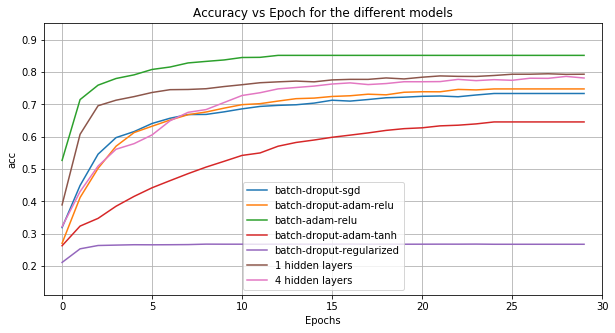

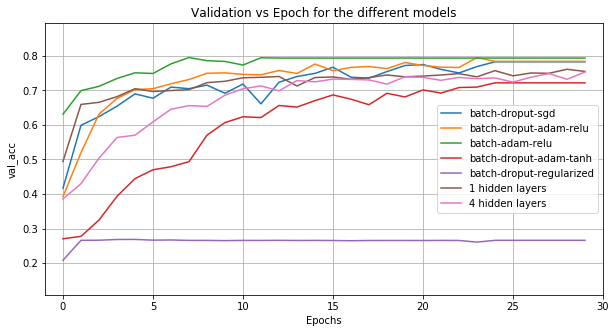

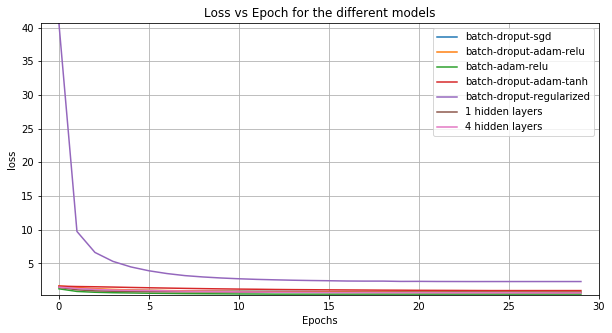

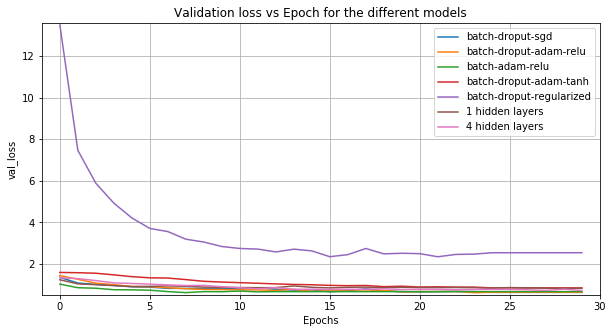

In [62]:
to_plot = [[history_online_net_sgd, 'batch-droput-sgd'], 
           [history_online_net_adam_relu, 'batch-droput-adam-relu'],
           [history_online_net_adam_relu_nodropout, 'batch-adam-relu'],
           [history_online_net_adam_tanh, 'batch-droput-adam-tanh'],
           [history_online_net_adam_relu_regularized, 'batch-droput-regularized'], 
          ]
#add 1 hidden and 4 hidden layers
to_plot.append(multilayer_results[0])
to_plot.append(multilayer_results[-1])
g =  'vs Epoch for the different models'
plot_histories_charact(to_plot, num_epochs, 'acc', 'Accuracy ' + g)
plot_histories_charact(to_plot, num_epochs, 'val_acc', 'Validation ' + g)
plot_histories_charact(to_plot, num_epochs, 'loss', 'Loss ' + g)
plot_histories_charact(to_plot, num_epochs, 'val_loss', 'Validation loss ' + g)

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [119]:
x_images = x_train[:]
x_images = np.reshape(x_images, (x_train.shape[0], 16, 16, 1))
y_images = y_train[:]
y_images = np.reshape(y_images, (y_train.shape[0], 5))
x_images_test = x_test[:]
x_images_test = np.reshape(x_images_test, (x_test.shape[0], 16, 16, 1))
y_images_test = y_test[:]
y_images_test = np.reshape(y_images_test, (y_test.shape[0], 5))

In [130]:
# set number of epochs for all convolutionals
num_epochs = 50
input_shape = (16, 16, 1)

In [121]:
# testing a model of convolutional neural networ

model_convolutional = Sequential()
model_convolutional.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_convolutional.add(Conv2D(64, (3, 3), activation='relu'))
model_convolutional.add(MaxPooling2D(pool_size=(2, 2)))
model_convolutional.add(Dropout(0.25))
model_convolutional.add(Flatten())
model_convolutional.add(Dense(128, activation='relu'))
model_convolutional.add(Dropout(0.5))
model_convolutional.add(Dense(5, activation='softmax'))

model_convolutional.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['acc'])

hist_convolutional1 = model_convolutional.fit(x_images, y_images,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=0,
         validation_data=(x_images_test, y_images_test))

Train on 31900 samples, validate on 11549 samples
Epoch 1/15
 - 26s - loss: 1.0597 - acc: 0.5843 - val_loss: 0.5415 - val_acc: 0.8174
Epoch 2/15
 - 23s - loss: 0.4296 - acc: 0.8657 - val_loss: 0.3440 - val_acc: 0.8967
Epoch 3/15
 - 24s - loss: 0.3434 - acc: 0.8908 - val_loss: 0.3053 - val_acc: 0.9035
Epoch 4/15
 - 24s - loss: 0.3029 - acc: 0.9023 - val_loss: 0.2641 - val_acc: 0.9192
Epoch 5/15
 - 24s - loss: 0.2732 - acc: 0.9117 - val_loss: 0.2747 - val_acc: 0.9142
Epoch 6/15
 - 24s - loss: 0.2535 - acc: 0.9170 - val_loss: 0.2639 - val_acc: 0.9147
Epoch 7/15
 - 24s - loss: 0.2383 - acc: 0.9231 - val_loss: 0.2348 - val_acc: 0.9282
Epoch 8/15
 - 24s - loss: 0.2253 - acc: 0.9264 - val_loss: 0.2398 - val_acc: 0.9243
Epoch 9/15
 - 26s - loss: 0.2183 - acc: 0.9295 - val_loss: 0.2273 - val_acc: 0.9294
Epoch 10/15
 - 24s - loss: 0.2092 - acc: 0.9322 - val_loss: 0.2297 - val_acc: 0.9292
Epoch 11/15
 - 24s - loss: 0.1982 - acc: 0.9370 - val_loss: 0.2164 - val_acc: 0.9326
Epoch 12/15
 - 24s - los

Test loss: 0.21053202026168427
Test accuracy: 0.9343666118846351


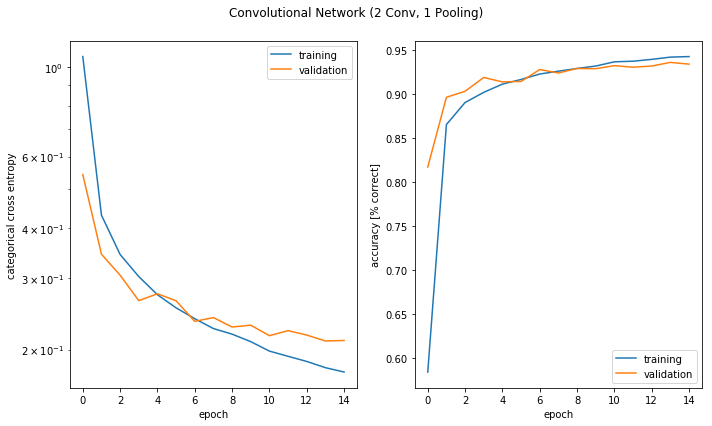

In [122]:
score = model_convolutional.evaluate(x_images_test, y_images_test, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
_ = plot_history(hist_convolutional1, 'Convolutional Network (2 Conv, 1 Pooling)')


In [123]:
# testing a model of convolutional neural networ

model_convolutional2 = Sequential()
model_convolutional2.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_convolutional2.add(Dropout(0.15))
model_convolutional2.add(BatchNormalization())
model_convolutional2.add(Conv2D(32, (3, 3), activation='relu'))
model_convolutional2.add(MaxPooling2D(pool_size=(2, 2)))
model_convolutional2.add(Dropout(0.25))
model_convolutional2.add(Flatten())
model_convolutional2.add(Dense(128, activation='relu'))
model_convolutional2.add(Dropout(0.5))
model_convolutional2.add(Dense(5, activation='softmax'))

model_convolutional2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['acc'])

hist_convolutional2 = model_convolutional2.fit(x_images, y_images,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=0,
         validation_data=(x_images_test, y_images_test))

Train on 31900 samples, validate on 11549 samples
Epoch 1/15
 - 63s - loss: 0.8261 - acc: 0.6861 - val_loss: 0.4102 - val_acc: 0.8695
Epoch 2/15
 - 60s - loss: 0.4158 - acc: 0.8624 - val_loss: 0.3224 - val_acc: 0.8907
Epoch 3/15
 - 60s - loss: 0.3465 - acc: 0.8867 - val_loss: 0.2803 - val_acc: 0.9144
Epoch 4/15
 - 60s - loss: 0.3091 - acc: 0.8983 - val_loss: 0.3209 - val_acc: 0.8977
Epoch 5/15
 - 60s - loss: 0.2863 - acc: 0.9057 - val_loss: 0.2537 - val_acc: 0.9196
Epoch 6/15
 - 60s - loss: 0.2708 - acc: 0.9117 - val_loss: 0.2275 - val_acc: 0.9279
Epoch 7/15
 - 60s - loss: 0.2563 - acc: 0.9154 - val_loss: 0.2289 - val_acc: 0.9279
Epoch 8/15
 - 61s - loss: 0.2494 - acc: 0.9194 - val_loss: 0.2298 - val_acc: 0.9295
Epoch 9/15
 - 59s - loss: 0.2380 - acc: 0.9227 - val_loss: 0.2194 - val_acc: 0.9289
Epoch 10/15
 - 61s - loss: 0.2261 - acc: 0.9257 - val_loss: 0.2424 - val_acc: 0.9248
Epoch 11/15
 - 60s - loss: 0.2226 - acc: 0.9269 - val_loss: 0.2130 - val_acc: 0.9300
Epoch 12/15
 - 61s - los

Test loss: 0.233897079082627
Test accuracy: 0.9286518312809384


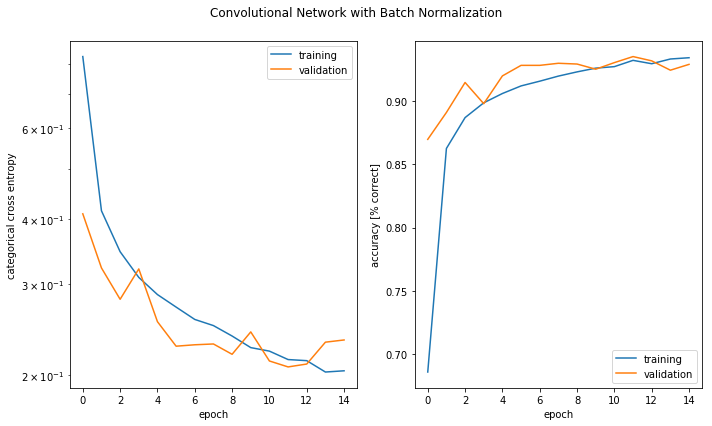

In [124]:
score = model_convolutional2.evaluate(x_images_test, y_images_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
_ = plot_history(hist_convolutional2, 'Convolutional Network with Batch Normalization')

In [131]:
# trying with a deeper network

model_convolutional3 = Sequential()
model_convolutional3.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_convolutional3.add(Conv2D(64, (3, 3), activation='relu'))
model_convolutional3.add(MaxPooling2D(pool_size=(2, 2)))
model_convolutional3.add(Dropout(0.25))
model_convolutional3.add(Conv2D(128, (3, 3), activation='relu'))
model_convolutional3.add(MaxPooling2D(pool_size=(2, 2)))
model_convolutional3.add(Dropout(0.5))
model_convolutional3.add(Flatten())
model_convolutional3.add(Dense(128, activation='relu'))
model_convolutional3.add(Dropout(0.5))
model_convolutional3.add(Dense(5, activation='softmax'))

model_convolutional3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['acc'])

hist_convolutional3 = model_convolutional3.fit(x_images, y_images,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=0,
         validation_data=(x_images_test, y_images_test))

Train on 31900 samples, validate on 11549 samples
Epoch 1/25
 - 34s - loss: 1.2601 - acc: 0.4788 - val_loss: 0.5767 - val_acc: 0.8130
Epoch 2/25
 - 29s - loss: 0.5179 - acc: 0.8283 - val_loss: 0.3829 - val_acc: 0.8685
Epoch 3/25
 - 29s - loss: 0.3864 - acc: 0.8721 - val_loss: 0.4469 - val_acc: 0.8476
Epoch 4/25
 - 31s - loss: 0.3358 - acc: 0.8901 - val_loss: 0.2737 - val_acc: 0.9089
Epoch 5/25
 - 32s - loss: 0.3045 - acc: 0.8991 - val_loss: 0.2501 - val_acc: 0.9192
Epoch 6/25
 - 37s - loss: 0.2886 - acc: 0.9066 - val_loss: 0.2359 - val_acc: 0.9222
Epoch 7/25
 - 32s - loss: 0.2657 - acc: 0.9136 - val_loss: 0.2289 - val_acc: 0.9267
Epoch 8/25
 - 29s - loss: 0.2516 - acc: 0.9170 - val_loss: 0.2354 - val_acc: 0.9236
Epoch 9/25
 - 29s - loss: 0.2416 - acc: 0.9213 - val_loss: 0.2025 - val_acc: 0.9349
Epoch 10/25
 - 34s - loss: 0.2320 - acc: 0.9230 - val_loss: 0.2273 - val_acc: 0.9220
Epoch 11/25
 - 31s - loss: 0.2290 - acc: 0.9255 - val_loss: 0.1992 - val_acc: 0.9346
Epoch 12/25
 - 29s - los

Test loss: 0.1662545865644355
Test accuracy: 0.9471815741158159


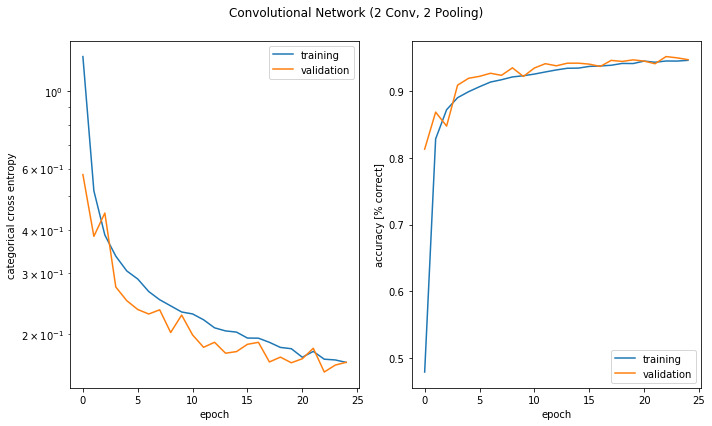

In [132]:
score = model_convolutional3.evaluate(x_images_test, y_images_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
_ = plot_history(hist_convolutional3, 'Convolutional Network (2 Conv, 2 Pooling)')

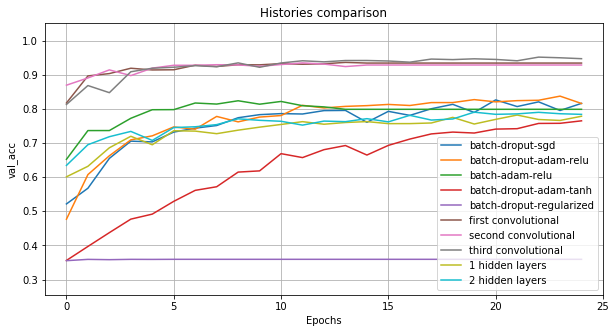

In [133]:
to_plot = [[history_online_net_sgd, 'batch-droput-sgd'], 
           [history_online_net_adam_relu, 'batch-droput-adam-relu'],
           [history_online_net_adam_relu_nodropout, 'batch-adam-relu'],
           [history_online_net_adam_tanh, 'batch-droput-adam-tanh'],
           [hist_convolutional1, 'first convolutional'],
           [hist_convolutional2, 'second convolutional'],
           [hist_convolutional3, 'third convolutional']
          ]
to_plot.append(multilayer_results[0])
to_plot.append(multilayer_results[-1])
plot_histories_charact(to_plot, num_epochs)

number of errors: 610
percentage of error: 5.281842583773487


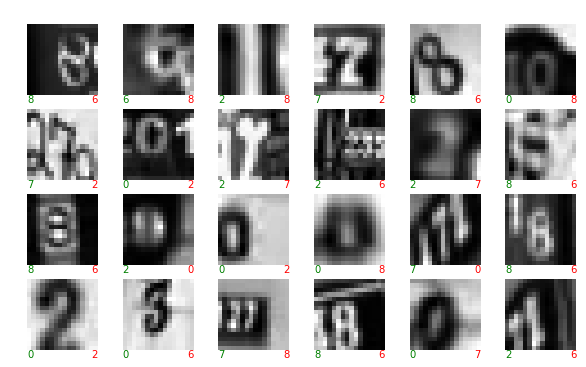

In [134]:
#in this section i would like to show which are the images that the network misjudge
predictions = model_convolutional.predict(x_images_test)
error_indices = plot_errors_examples(model_convolutional3, x_images_test, y_images_test, batch_size, subset_of_classes)

print("number of errors:", len(error_indices))
print("percentage of error:", (float(len(error_indices))/len(predictions))*100)

In [135]:
print(model_convolutional3.summary())
# 158.000 parameters

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 2, 2, 128)         0         
__________